In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract

import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import itk

import numpy as np

import site
site.addsitedir('../../../ARGUS')
from ARGUSUtils_Transforms import *

In [5]:
img1_dir = "../../../Data/VFoldData/BAMC-PTX*Sliding-Annotations-Linear/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*_?????.mha')))
all_labels = sorted(glob(os.path.join(img1_dir, '*.interpolated-overlay.mha')))

num_classes = 4
num_workers_te = 0
batch_size_te = 4

root_dir = "."
model_filename_base = "BAMC_PTX_3DUNet-4Class.best_model.vfold"

num_images = len(all_images)
print(num_images)
num_folds = 10


ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns','219ns','221ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

fold_prefix_list = []
ns_count = 0
s_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_ns = 2
        num_s = 1
        if i > num_folds-3:
            num_s = 2
    else:
        num_ns = 1
        num_s = 2
    f = []
    for ns in range(num_ns):
        f.append([ns_prefix[ns_count+ns]])
    ns_count += num_ns
    for s in range(num_s):
        f.append([s_prefix[s_count+s]])
    s_count += num_s
    fold_prefix_list.append(f)
        
train_files = []
val_files = []
test_files = []
for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

62
49 8 5
51 5 6
50 6 6
50 6 6
51 6 5
51 5 6
50 6 6
49 6 7
48 7 7
47 7 8


In [6]:
test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(keys=["image"],
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0),
        ARGUS_RandSpatialCropSlicesd(num_slices=48,
            axis=2,
            center_slice=30,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

In [7]:
test_ds = [Dataset(data=test_files[i], transform=test_transforms)
          for i in range(num_folds)]
test_loader = [DataLoader(test_ds[i], batch_size=1, num_workers=num_workers_te)
              for i in range(num_folds)]

In [8]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:1")

In [28]:
def plot_vfold_training_curves(vfold_num, test_loader):
    print("VFOLD =", vfold_num, "of", num_folds)

    loss_file = os.path.join(root_dir, model_filename_base+"_loss_"+str(vfold_num)+".npy")
    if os.path.exists(loss_file):
        epoch_loss_values = np.load(loss_file)
        
        metric_file = os.path.join(root_dir, model_filename_base+"_val_dice_"+str(vfold_num)+".npy")
        metric_values = np.load(metric_file)
    
        plt.figure("train", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title("Epoch Average Loss")
        x = [i + 1 for i in range(len(epoch_loss_values))]
        y = epoch_loss_values
        plt.xlabel("epoch")
        plt.plot(x, y)
        plt.subplot(1, 2, 2)
        plt.title("Val Mean Dice")
        x = [2 * (i + 1) for i in range(len(metric_values))]
        y = metric_values
        plt.xlabel("epoch")
        plt.plot(x, y)
        plt.show()
    
    model_file = os.path.join(root_dir, model_filename_base+'_'+str(vfold_num)+'.pth')
    if os.path.exists(model_file):
        model = UNet(
            dimensions=3,
            in_channels=1,
            out_channels=num_classes,
            channels=(16, 32, 64, 128),
            strides=(2, 2, 2),
            num_res_units=2,
            norm=Norm.BATCH,
        ).to(device)    
        model.load_state_dict(torch.load(model_file))
        model.eval()
        with torch.no_grad():
            i = 0
            for b,test_data in enumerate(test_loader):
                roi_size = (320, 320, 48)
                sw_batch_size = 4
                test_outputs = sliding_window_inference(
                    test_data["image"].to(device), roi_size, sw_batch_size, model
                )
                for j in range(test_outputs.shape[0]):
                    print(test_files[i][0]["image"])
                    plt.figure("check", (18, 6))
                    plt.subplot(1, 3, 1)
                    plt.title(f"image {i}")
                    tmpV = test_data["image"][j, 0, :, :, 10]
                    plt.imshow(tmpV, cmap="gray")
                    plt.subplot(1, 3, 2)
                    plt.title(f"label {i}")
                    tmpV = test_data["label"][j, 0, :, :, 10]
                    tmpV[0,0]=1
                    tmpV[0,1]=2
                    tmpV[0,2]=3
                    plt.imshow(tmpV)
                    plt.subplot(1, 3, 3)
                    plt.title(f"output {i}")
                    tmpV = torch.argmax(test_outputs, dim=1).detach().cpu()[j, :, :, 10]
                    tmpV[0,0]=1
                    tmpV[0,1]=2
                    tmpV[0,2]=3
                    plt.imshow(tmpV)
                    plt.show()
                    i += 1

VFOLD = 0 of 10
../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/247ns_image_2734882394424_CLEAN.mha


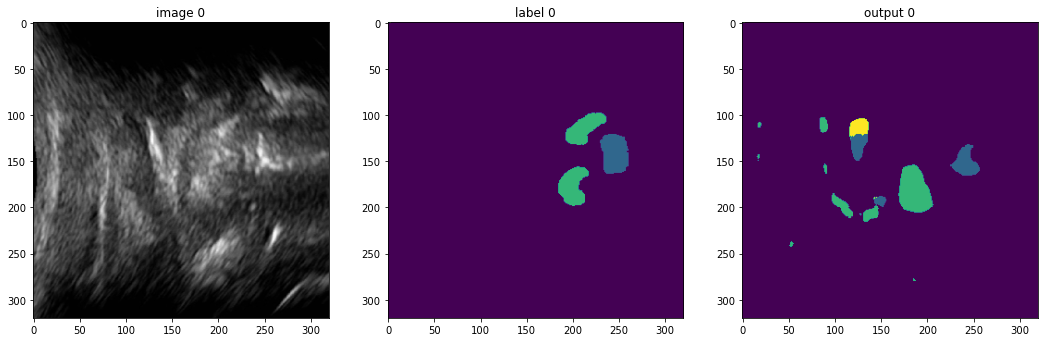

../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/025ns_Image_262499828648_clean.mha


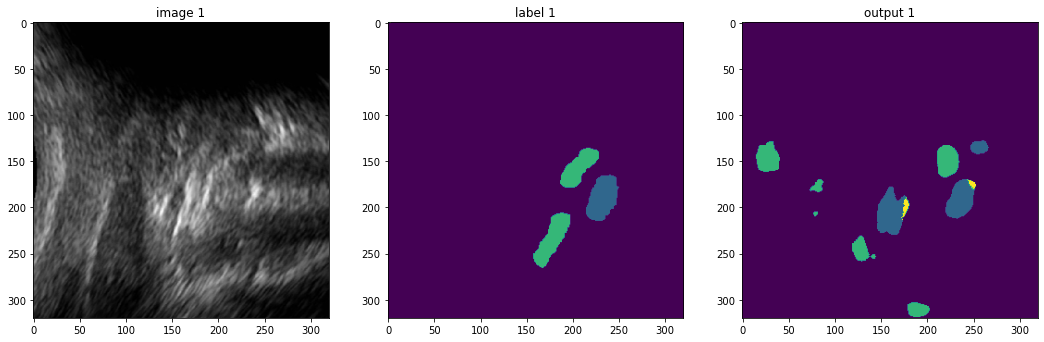

../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/027ns_image_4641643404894_CLEAN.mha


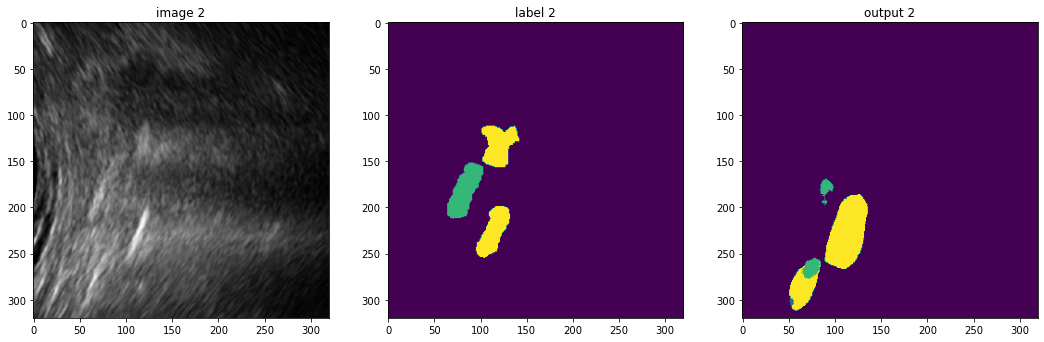

../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/035ns_image_1394469579519_clean.mha


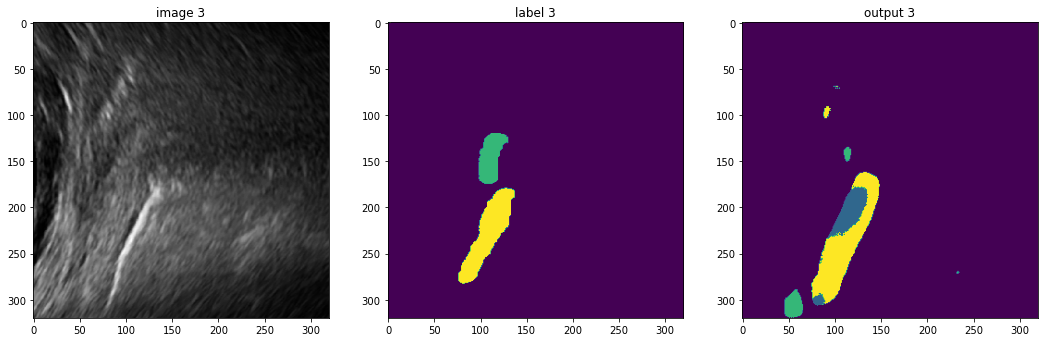

../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/055ns_image_27180764486244_CLEAN.mha


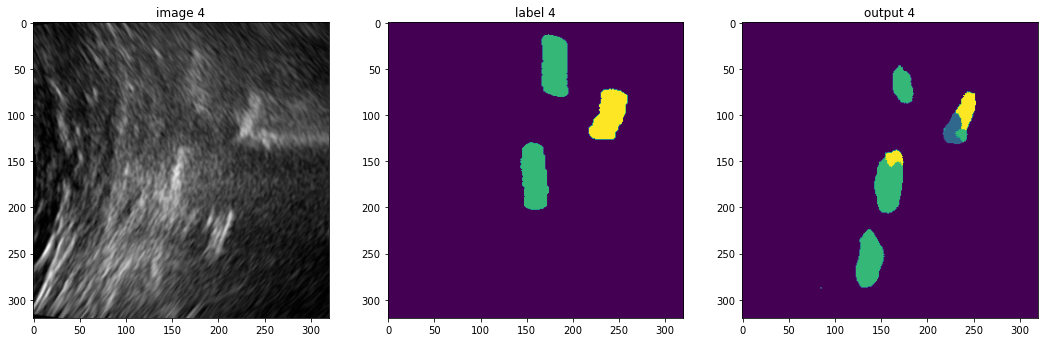

VFOLD = 1 of 10
../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/247ns_image_2734882394424_CLEAN.mha


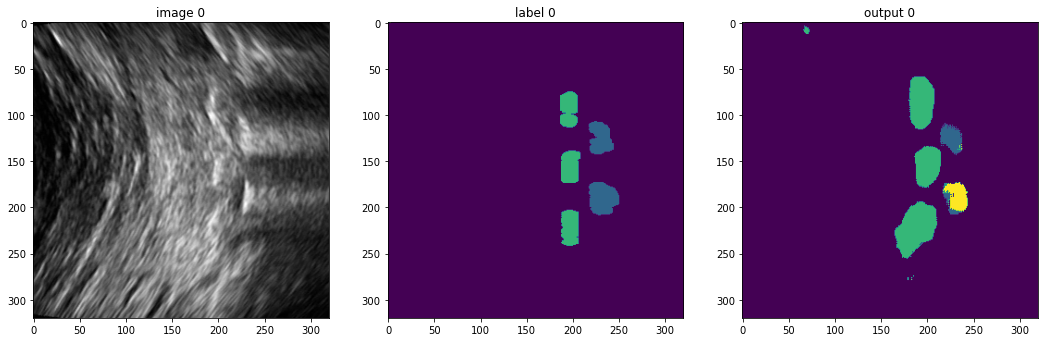

../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/025ns_Image_262499828648_clean.mha


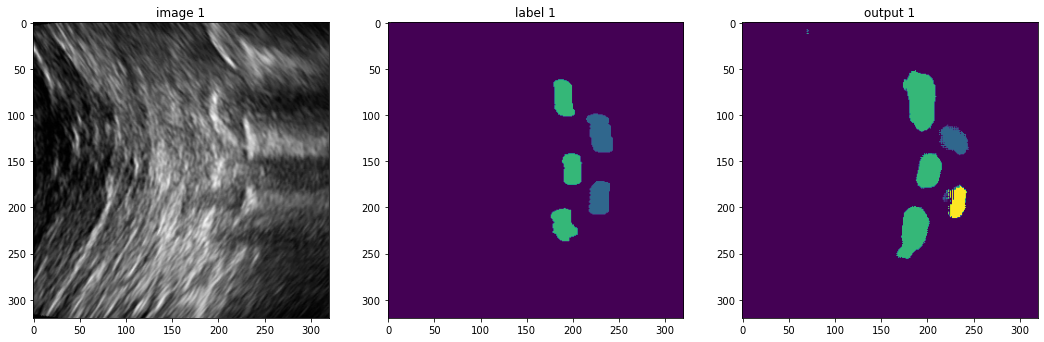

../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/027ns_image_4641643404894_CLEAN.mha


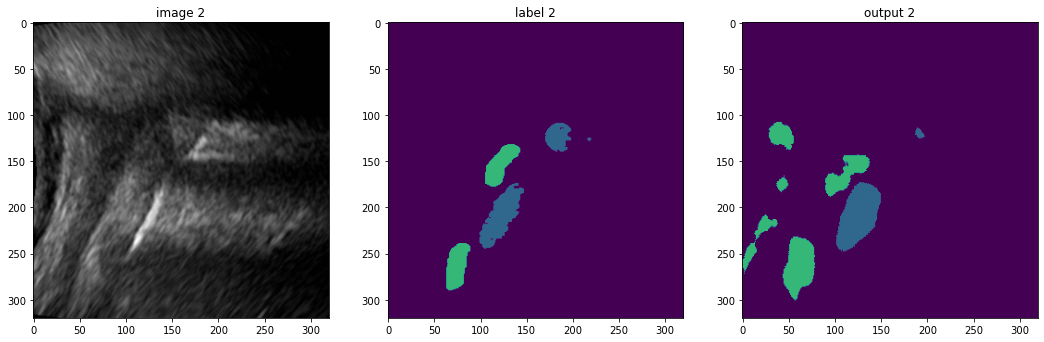

../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/035ns_image_1394469579519_clean.mha


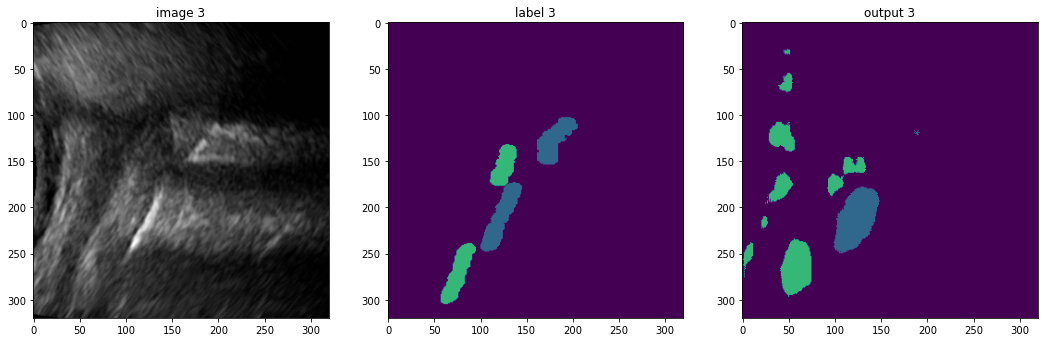

../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/055ns_image_27180764486244_CLEAN.mha


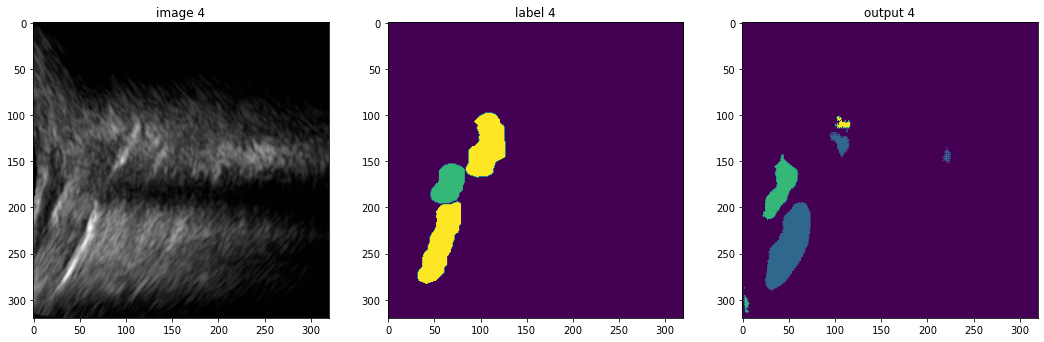

../../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/117ns_image_417221672548_CLEAN.mha


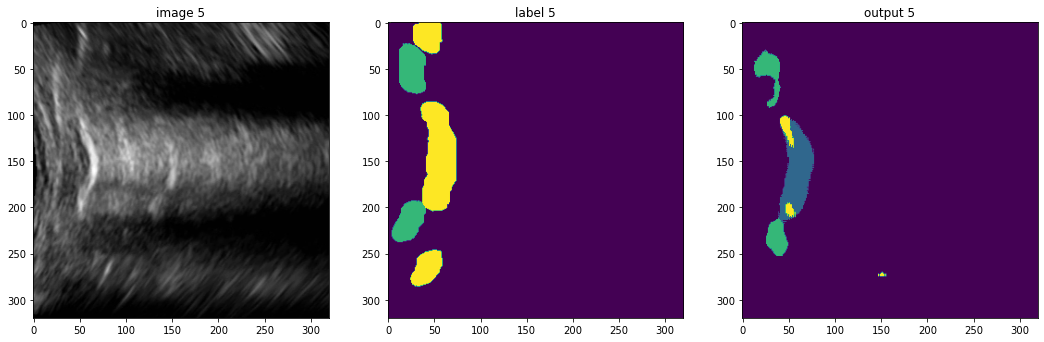

VFOLD = 2 of 10


TypeError: load() missing 1 required positional argument: 'file'

In [29]:
for i in range(num_folds):
    plot_vfold_training_curves(i, test_loader[i])

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "BAMC_PTX_3DUNet-4Class.best_model.pth")))
model.eval()
with torch.no_grad():
    i = 0
    for b,val_data in enumerate(val_loader):
        roi_size = (320, 320, 48)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        for j in range(val_outputs.shape[0]):
            print(val_images[i])
            plt.figure("check", (18, 6))
            plt.subplot(1, 3, 1)
            plt.title(f"image {i}")
            tmpV = val_data["image"][j, 0, :, :, 10]
            plt.imshow(tmpV, cmap="gray")
            plt.subplot(1, 3, 2)
            plt.title(f"label {i}")
            tmpV = val_data["label"][j, 0, :, :, 10]
            tmpV[0,0]=1
            tmpV[0,1]=2
            tmpV[0,2]=3
            plt.imshow(tmpV)
            plt.subplot(1, 3, 3)
            plt.title(f"output {i}")
            tmpV = torch.argmax(val_outputs, dim=1).detach().cpu()[j, :, :, 10]
            tmpV[0,0]=1
            tmpV[0,1]=2
            tmpV[0,2]=3
            plt.imshow(tmpV)
            plt.show()
            i += 1